# Actividad Integradora 1
### Equipo 2:
Héctor Gibrán González Leal [A01282278]  
Julio César García Flores [A00516860]  
Gustavo De Los Ríos Alatorre [A01410922]  
Jacobo Cruz Romero [A01067040]  
David Garza Gonzalez [A00820764]

En este notebook estaremos desarrollando una aplicación para realizar **sentiment analysis** sobre tweets tomados directamente de la API de Twitter, así como otras aplicaciones como comentarios de Reddit y Youtube, además de lyrics de canciones de Genius.com.

Antes que nada, se instalan los módulos necesarios utilizando el archivo de requirements que se proporciona.

In [1]:
pip install -r requirements.txt

     |████████████████████████████████| 7.0MB 8.0MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 37.6MB 74.4MB/s 
     |████████████████████████████████| 163kB 56.1MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 645kB 44.4MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 552kB 47.1MB/s 
     |████████████████████████████████| 1.2MB 44.2MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 358kB 40.0MB/s 
     |████████████████████████████████| 706kB 44.5MB/s 
     |████████████████████████████████| 174kB 56.5MB/s 
     |████████████████████████████████| 3.4MB 48.1MB/s 
     |████████████████████████████████| 1.1MB 40.9MB/s 
     |████████████████████████████████| 358kB 50.7MB/s 
     |████████████████████████████████| 1.9MB 37.7MB/s 
     |████████████████████████████████| 61kB 9.2MB/s

Se importan los módulos que se estarán usando

In [2]:
# Módulos de NLTK
import nltk
from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.classify import ClassifierI
from nltk.stem import WordNetLemmatizer

# Módulos de SKLearn
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, log_loss

# Módulos de Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

# Módulos del Twitter API
from tweepy import API
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
#import sentiment_mod as s
import time

# Módulos para la API de Genius
from lyricsgenius import Genius

# Módulo para speech recognition con SpeechBrain
from speechbrain.pretrained import EncoderDecoderASR

# Módulo para el API de Youtube
from googleapiclient.discovery import build

# Módulo para API de Reddit
import praw
from praw.models import MoreComments

# Módulos generales
import io
import os
import pandas as pd
import numpy as np
import re
import random
import pickle
import shutil
from statistics import mode
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from matplotlib import style

# Descargar paquetes necesarios por si acaso
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# 1. Gathering Data

Lo primero que se hará es importar el dataset con los tweets ya clasificados. Nosotros incorporamos el dataset de Kaggle llamado 'Tweets Sentiment Analysis' (https://www.kaggle.com/youben/tweets-sentiment-analysis). Más especificamente, estamos utilizando el archivo de 'Train.csv', que contiene alrededor de 100,000 tweets, para generar los sets de training, validation y testing.

In [3]:
pd.options.display.max_colwidth = 200
data = pd.read_csv('train.csv', encoding='ISO-8859-1')

# 2. Preparing the Data
Antes de hacer cualquier modificación, vamos a mostrar algunas filas del dataset aleatorias para inspeccionar más de cerca su contenido

In [4]:
random.seed(12345)
indexes = np.random.randint(1, len(data), 20).tolist()
data.iloc[indexes]

,ItemID,Sentiment,SentimentText
13868,13880,1,..... a cool day lying in the sun at hyde park with my sweet mandy
90533,90545,1,@ChinaBlue79 Awww you don't look a day older than Sonic The Hedgehog
90850,90862,0,@CNICELB me to fam... i had many tears earlier from my friends funeral how was ur dai?
6712,6715,0,"#followfriday @mikegrant Twitter is too quiet without him, miss ya dude"
73527,73539,1,@ankit_a Professional work costs more! English-Hindi translation will be a big business in next few years. Keep tuned in.
90339,90351,1,@chiefsanjay I thought aap US mein ho..and you did not inform us
28498,28510,1,@air1radio Absolutely. It's nice to get the verses daily Thanks!
92571,92583,1,@chriskey They found me - I've no idea where they've even come from! I only know you
6266,6269,0,#DontYouHate when your favorite member of a music group is no longer part of the group?! HEATED! I loved her @Tifflicious *sigh*
73657,73669,0,smoked prime rib working...


Como se puede observar, el dataset contiene 3 cosas: **un id, la clasificación (positiva o negativa) y el texto del tweet**. De las cuales, nos estaremos enfocando en las últimas dos.

Ahora bien, queremos enfocarnos un poco en el texto de los tweets. Viendo algunos de los textos, es claro que hay ciertas cosas que no ayudan mucho a definir la clasificación del tweet. Por lo tanto, haremos algo de **pre-procesamiento** antes de meter los tweets al modelo.

La primera función cumple dos propósitos: **'lemmatizar' y 'tokenizar'** los tweets. Con la primera, lo que queremos es regresar las palabras a su raíz, con el objetivo de que palabras como 'running' y 'ran' se tomen como la misma. Y la segunda, va a dividir el texto del tweet en palabras, y estas se regresarán en una lista. Además de esto, es importante mencionar que sólo vamos a incluir palabras que **no sean stopwords**, por la razón que estas no terminan aportando al sentimiento del tweet.

In [5]:
stop_words = set(stopwords.words("english") + [',', '...', '.', '..', "'", '’', 'rt', ':']) - set(words.words())

In [6]:
def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(token.lower()) for token in word_tokenize(text) if token not in stop_words])

La segunda función va a quitar o arreglar ciertas cosas que notamos en los textos que creemos que no aportan mucho para determinar su clasificación. Más específicamente, haremos lo siguiente:


*   **Sustituir los @tags por 'tag'**, dado que las menciones específicas no terminan aportando mucho, pero el hecho de que haya una mención puede que sí afecte.
*   **Remover los hashtags (#)**, nadamás se removerá el signo de #, la palabra que viene después se queda igual.
*   **Remover los caracteres especiales de HTML**, notamos que hay cosas como '&quot', que no vienen sirviendo mucho.
*   **Sustituir los emojis**, al igual que los hashtags, creemos que sería mucho más útil agrupar todos los emojis positivos y separarlos de los negativos.
*   **Remover los urls**, en el sentido de que se removerán los caracteres especiales y sólo se dejarán las palabras importantes de este.
*   **Remover caracteres repetidos**, para agrupar palabras como 'heelloooo' en una sola
*   **Remover menciones a otros subreddits**
*   **Remover menciones a usuarios de Reddit**

Finalmente, esta función regresa el texto procesado por la función anterior para así guardarlo. Esta función será usada para procesar todos los textos que rcibamos. Esto incluye **el dataset, API de Twitter, Youtube, Reddit y Genius**.

In [7]:
def process_text(text):
    # Remover los @ tags
    text = re.sub(r"@[a-zA-Z0-9_]*", "tag", text)

    # Remover los hashtags y dejar solo la palabra
    text = re.sub(r"#", "", text)

    # Remover los caracteres especiales de HTML
    text = re.sub(r"\&\w+;", "", text)

    # Remover las tags de HTML
    text = re.sub(r"<[^>]+>", "", text)

    # Reemplazar los emojis
    HAPPY_EMO = r"([xX;:]-?[dD\)]|:-?[\\\)]|[;:][pP])" # tomada de https://stackoverflow.com/questions/28077049/regex-matching-emoticons
    SAD_EMO = SAD_EMO = r"(:'?[/|\(])" # tomada de https://stackoverflow.com/questions/28077049/regex-matching-emoticons

    text = re.sub(HAPPY_EMO, " happyemoticon ", text)
    text = re.sub(SAD_EMO, " sademoticon ", text)

    # Remover los hyperlinks
    text = re.sub(r"htpps?://\S+|www\.\S+", "", text)

    # Remover caracteres repetidos
    text = re.sub(r"(.)\1+", r"\1\1", text)

    # Remover menciones a subreddits
    text = re.sub(r"r\/([^\s/]+)", r"", text) # regex tomada de https://stackoverflow.com/questions/21109968/python-regex-to-match-subreddit-names

    # Remover menciones a otros usuarios de Reddit
    text = re.sub(r"\/([^\s/]+)", r"", text) # regex tomada de https://stackoverflow.com/questions/46104630/regex-to-identify-reddit-usernames

    return text

Ya con las funciones definidas, tomamos los tweets y los pasamos por ambas funciones para generar los tweets procesados. Ya con estos podemos proceder a utilizarlos para entrenar los modelos. Al final de esta celda se muestra el porcentaje de tweets negativos vs. positivos, para mostrar una mejor idea del dataset.

In [8]:
processed_ds = data.SentimentText.map(lambda tweet: lemmatize_tokenize(process_text(tweet)))

n_pos = data.Sentiment[(data['Sentiment'] == 1)].shape[0]
n_neg = data.Sentiment[(data['Sentiment'] == 0)].shape[0]
print(f"Negativos: {n_neg / len(data) * 100} %, \nPositivos: {n_pos / len(data) * 100} %")

Negativos: 43.53678904679515 %, 
Positivos: 56.46321095320486 %


# 3. Words as Features
Ahora que los tweets ya están listos, podemos armar nuestra lista de todas las palabras relevantes, de las cuales se usarán las 5000 más frecuentes. También, se restrigirán las palabras permitidas a solo **verbos**, **adjetivos** y **adverbios**.

In [9]:
documents = []
all_words = []
allowed_word_types = ['J', 'R', 'V']

for tweet, sent in zip(processed_ds, data.Sentiment):
    documents.append((tweet, sent))
    pos = nltk.pos_tag(word_tokenize(tweet))
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

all_words = nltk.FreqDist(all_words)
word_features = list(all_words.keys())[:5000] # lista con las 5000 palabras permitidas mas frecuentes

Definimos una función para sacar las **'features'** de un texto, es decir, una lista donde se indica cuales de las palabras están presentes en las más frecuentes. 

In [10]:
def find_features(words):
    features = []
    unknown = 1
    for index, w in enumerate(word_features):
        if w in words:
          val = 1
          unknown = 0
        else:
          val = 0

        features.append(val)
    features.append(unknown)
    return features

Usamos esta función para sacar los sets de features para todos los tweets.

In [11]:
featuresets = np.array([find_features(word_tokenize(tweet)) for (tweet, sent) in documents])
featuresets.shape

(99989, 5001)

# 4. Training, Validation and Testing Sets
Esta es una parte importante, ya que la manera en que se construyan estos 3 sets de datos puede afectar los resultados de los modelos que se construyan más adelante. Para empezar, es importante mencionar que se van a construir dos tipos de modelos principales: **modelos básicos de ScikitLearn** y **redes neuronales recurrentes (RNNs) con Keras**. Debido a que estos trabajan de diferente forma, se construirán sets distintos entre los dos tipos de modelos. A continuación se describe la estructura de los datos para cada tipo, así como el razonamiento para hacerlo de esta forma.

Antes que nada, vamos a definir los tamaños que tendrá cada set de datos. Nosotros optamos por la siguiente distribución:
- 60% para **Training**
- 20% para **Validation**
- 20% para **Testing**

In [12]:
training_percentage = 0.60
validation_percentage = 0.20
training_set_size = int(len(data) * training_percentage)
validation_set_size = int(len(data) * validation_percentage)

### Modelos de ScikitLearn
Estos son modelos sencillos, que para entrenarlos les vamos a alimentar los vectores de features que se crearon previamente. Es decir, cada ejemplo del dataset será un **one-hot encoding** del tweet, donde cada posición representa una de las 5 mil palabras más frecuentes, y el valor indica si está presente en el tweet o no. Y como ya sabemos, esta representacion es la que se generó con los **featuresets**. Se define de la siguiente forma:

In [13]:
training_set_sk = featuresets[:training_set_size]
validation_set_sk = featuresets[training_set_size : (training_set_size+validation_set_size)]
testing_set_sk = featuresets[(training_set_size+validation_set_size):]

training_sents_sk = np.array(data.Sentiment[:training_set_size])
validation_sents_sk = np.array(data.Sentiment[training_set_size : (training_set_size+validation_set_size)])
testing_sents_sk = np.array(data.Sentiment[(training_set_size+validation_set_size):])

print(training_set_sk.shape)
print(validation_set_sk.shape)
print(testing_set_sk.shape)

(59993, 5001)
(19997, 5001)
(19999, 5001)


### RNNs con Keras
Ahora bien, la segunda clase de modelos que implementaremos son diferentes arquitecturas de Redes Neuronales Recurrentes (RNNs) que implementaremos con el API de Keras. Una característica muy importante de este tipo de arquitecturas es que trabajan muy bien con **secuencias**, de ahí que sean tan populares para trabajar con texto. No obstante, en la representación de los featuresets no se puede apreciar ninguna clase de secuencia, dado que los ejempos sólo son vectores de 0s y 1s.

Por esta razón, cambiamos la estructura de la entrada de la siguiente forma: apoyándonos de Keras, vamos a contruir un vocabulario para las palabras más frecuentes, de tal manera que nos ayude a mapear palabras con índices. Entonces, nuestros vectores pasarían de ser booleanos a una lista de diferentes índices, en donde en claro que se está manteniendo la **secuencia de las palabras**, sólo que en una representación numérica para poder alimentarla a las redes.

Para lograr esto, primero creamos los datasets con tensores de Tensorflow. Algo que vale la pena mencionar es que los sets de datos contienen tuplas que agrupan el texto con su clasificación, por lo que ya no se necesita tener las labels en un set de datos aparte.

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_ds[:training_set_size], data.Sentiment[:training_set_size]))
valid_dataset = tf.data.Dataset.from_tensor_slices((processed_ds[training_set_size : (training_set_size+validation_set_size)], data.Sentiment[training_set_size : (training_set_size+validation_set_size)]))
test_dataset = tf.data.Dataset.from_tensor_slices((processed_ds[(training_set_size+validation_set_size):], data.Sentiment[(training_set_size+validation_set_size):]))

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

59993
19997
19999


Ahora lo que se hace es dividir los sets de datos en batches para poder llevar a cabo el entrenamiento. También, se hace un shuffle en los datos de entrenamiento.

In [15]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Ahora sí, apoyándonos de Keras, creamos el vocabulario que contendrá las **2000 palabras más frecuentes** (número definido por nosotros) a partir de training set. Al final de esta celda se muestran las 20 palabras más frecuentes en el set de entrenamiento. Aquí se puede ver que se está haciendo algo muy similar a lo que se hizo con NLTK en los featuresets, sólo que más apropiado para las RNNs.

In [16]:
VOCAB_SIZE = 2000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'tag', 'i', 'the', 'to', 'you', 'a', 'it', 'and',
       'my', 'is', 'that', 'for', 's', 'in', 'nt', 'me', 'of', 'have'],
      dtype='<U15')

# 5. Models and Extra Functionality
Procedemos a crear los modelos que vamos a utilizar y también creamos funcionalidades adicionales para guardar y cargar los modelos ya entrenados, así como obtner métricas de desempeño y graficar los valores de loss.

Lo primero que definimos es la clase que representará el modelo principal, el **Vote Classifier**. El punto de este modelo es que va a englobar todos los demás modelos que construyamos, de tal forma que al querer clasificar un nuevo texto, este tomará las predicciones de todos los modelos y de acuerdo a la mayoría sacará la predicción definitiva.

Como se puede ver, debido a que este incluye modelos simples y complejos, escribimos dos funciones separadas para sacar las predicciones para cada tipo de modelo, después juntamos todos los votos para sacar la predicción definitiva.

In [17]:
class VoteClassifier(ClassifierI):
    def __init__(self, NB, multi_Nb, bern_NB, LR, SGD, rnn_one, rnn_two, rnn_three, bert_model):
        self.simple_classifiers = [NB, multi_Nb, bern_NB, LR, SGD]
        self.complex_classifiers = [rnn_one, rnn_two, rnn_three, bert_model]
        
    def classify(self, text):
        votes = self.classify_simple(text) + self.classify_complex(text)
        c_ones = sum(1 for v in votes if v == 1)
        c_zeros = sum(1 for v in votes if v == 0)
        confidence = c_ones / len(votes)

        if c_ones < c_zeros:
            confidence = 1 - confidence

        return mode(votes), confidence

    def classify_simple(self, text):
        votes = []
        feats = np.array(find_features(text)).reshape(1, -1)

        for c in self.simple_classifiers:
            v = c.predict(feats)[0]
            votes.append(v)
        return votes

    def classify_complex(self, text):
        votes = []

        for c in self.complex_classifiers:
            pred = c.predict(np.array([text]))
            v = 1 if pred >= 0.5 else 0
            votes.append(v)
        return votes

Aquí se presentan dos funciones que fueron muy útiles durante el desarrollo de este trabajo. Estas sirven para guardar el estado actual de los modelos, así como cargarlo nuevamente, con la finalidad de ahorrarse el tiempo de tener que entrenar los modelos varias veces.

In [18]:
def save_classifier(classifier, name):
    _name = os.path.join("/content/drive/MyDrive/SentDex", name + ".pickle")
    save_classifier = open(_name,"wb")
    pickle.dump(classifier, save_classifier)
    save_classifier.close()
    print(_name + " saved!")

def load_classifier(name):
    _name = os.path.join("/content/drive/MyDrive/SentDex", name + ".pickle")
    classifier_f = open(_name,"rb")
    classifier = pickle.load(classifier_f)
    classifier_f.close()
    print(_name + "loaded!")
    return classifier

# 6. Training, Evaluation, and Metrics
En este apartado entrenamos todos los modelos que formarán parte del vote classifier. Cuando se terminen de entrenar, se obtienen las siguientes métricas para valorar su desempeño:
- Accuracy
- Precision
- Recall

Asimismo, en caso de que sea posible se muestra la matriz de confusión graficada, así como otra gráfica con los valores de loss a lo largo del entrenamiento.

### Clasificadores de ScikitLearn

Decidimos crear los siguientes clasificadores de ScikitLearn:


*   Naive Bayes (Regular, Multinomial y Bernoulli)
*   Logistic Regression
*   Stochastic Gradient Descent

Antes de crealos, las siguientes celdas muestran varias algunas funciones útiles para estos modelos.


Como se mencionó antes, el set de datos contiene alrededor de 100,000 tweets. Dado que es una cantidad muy grande, tenemos que hacer el entrenamiento de los modelos en batches. En esta celda dividimos el set de entrenamiento en 60 batches, cada uno con sólo 1,000 tweets. 

In [19]:
# Tamaño del batch
n = 1000

# using list comprehension 
X_batches = [training_set_sk[i*n : (i + 1)*n] for i in range((len(training_set_sk) + n - 1) // n )]
Y_batches = [training_sents_sk[i*n : (i + 1)*n] for i in range((len(training_sents_sk) + n - 1) // n )]

Ya con el set de datos partido en batches, definimos una función que realizará el entrenamiento del modelo. Además del entrenamiento, también va guardando los valores loss por batch, y los regresa al terminar.

In [20]:

def train_mini_batch(classifier):
    index = 0
    losses = []

    for X,Y in zip(X_batches, Y_batches):
        classifier.partial_fit(X,Y, classes = [1, 0])

        preds = classifier.predict(validation_set_sk)
        losses.append(log_loss(validation_sents_sk, preds))

        index += 1
        if index % 10 == 0:
          print(f"Epoch: {index}")

    return losses

Esta es una función para englobar las 3 métricas de desempeño que se quieren mostrar por modelo. También, despliega la matriz de confusión.

In [21]:
def get_classifier_metrics(classifier):
    preds = classifier.predict(testing_set_sk)

    print("\tAccuracy: ", accuracy_score(testing_sents_sk, preds) * 100)
    print("\tPrecision: ", precision_score(testing_sents_sk, preds) * 100)
    print("\tRecall: ", recall_score(testing_sents_sk, preds) * 100)
    print()
    print("Confusion matrix: ")
    plot_confusion_matrix(classifier, testing_set_sk, testing_sents_sk)
  

La siguiente función es sólo para crear la gráfica para los valores de loss.

In [22]:
def plot_classifier_loss(classifier, losses):
    plt.figure(figsize=(4.8, 4))
    plt.plot(losses, 'red')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title(f"Log loss for {classifier}")
    plt.show()

Ahora sí, podemos entrenar los 5 modelos que se mencionaron antes. Al terminar, se muestran todas las métricas y gráficas que se especificaron previamente.

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60

Simple Naive Bayes metrics:
	Accuracy:  60.583029151457566
	Precision:  60.53093578762569
	Recall:  96.0817429488262

Confusion matrix: 


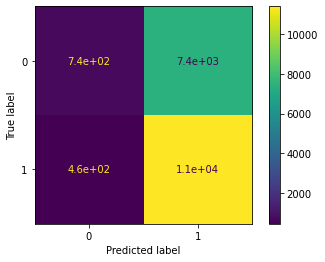

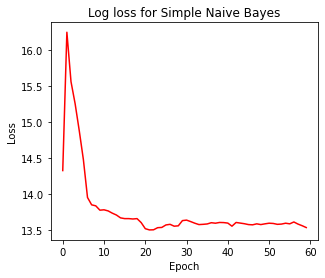

In [23]:
NB_classifier = GaussianNB()
losses = train_mini_batch(NB_classifier)
print()
print("Simple Naive Bayes metrics:")
get_classifier_metrics(NB_classifier)
plot_classifier_loss("Simple Naive Bayes", losses)

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60

Multinomial Naive Bayes metrics:
	Accuracy:  74.00370018500925
	Precision:  76.80142015653998
	Recall:  80.37493666610371

Confusion matrix: 


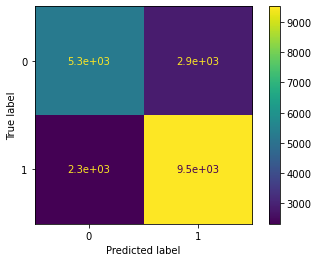

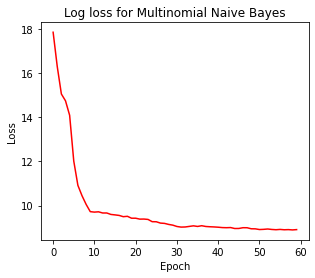

In [24]:
MNB_classifier = MultinomialNB()
losses = train_mini_batch(MNB_classifier)
print()
print("Multinomial Naive Bayes metrics:")
get_classifier_metrics(MNB_classifier)
plot_classifier_loss("Multinomial Naive Bayes", losses)

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60

Bernoulli Naive Bayes metrics:
	Accuracy:  73.38866943347168
	Precision:  75.60879811468972
	Recall:  81.27850025333558

Confusion matrix: 


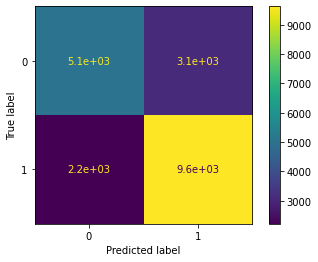

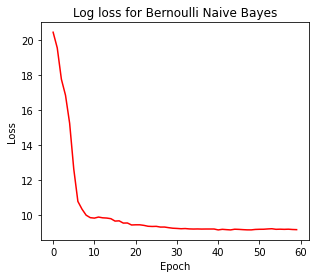

In [25]:
BNB_classifier = BernoulliNB()
losses = train_mini_batch(BNB_classifier)
print()
print("Bernoulli Naive Bayes metrics:")
get_classifier_metrics(BNB_classifier)
plot_classifier_loss("Bernoulli Naive Bayes", losses)

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60

Logistic Regression metrics:
	Accuracy:  71.35856792839643
	Precision:  78.41078066914498
	Recall:  71.2464110792096

Confusion matrix: 


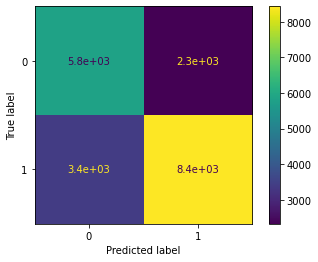

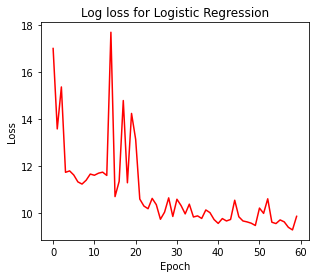

In [26]:
LogisticRegression_classifier = SGDClassifier(loss='log')
losses = train_mini_batch(LogisticRegression_classifier)
print()
print("Logistic Regression metrics:")
get_classifier_metrics(LogisticRegression_classifier)
plot_classifier_loss("Logistic Regression", losses)

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60

SGDC metrics:
	Accuracy:  72.16860843042153
	Precision:  77.30595196658545
	Recall:  75.0211112987671

Confusion matrix: 


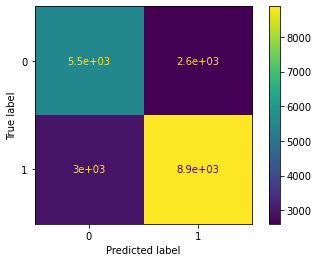

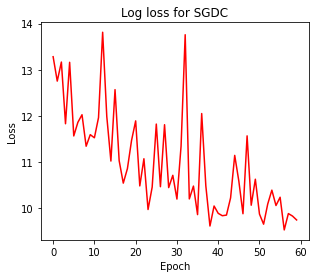

In [27]:
SGDClassifier_classifier = SGDClassifier()
losses = train_mini_batch(SGDClassifier_classifier)
print()
print("SGDC metrics:")
get_classifier_metrics(SGDClassifier_classifier)
plot_classifier_loss("SGDC", losses)

Aquí se cargan los modelos ya entrenados, en caso de que ya se tengan los archivos pickle.

In [28]:
"""
NB_classifier = load_classifier("NB_classifier")
MNB_classifier = load_classifier("MNB_classifier")
BNB_classifier = load_classifier("BNB_classifier")
LogisticRegression_classifier = load_classifier("LogisticRegression_classifier")
SGDClassifier_classifier = load_classifier("SGDClassifier_classifier")
"""

'\nNB_classifier = load_classifier("NB_classifier")\nMNB_classifier = load_classifier("MNB_classifier")\nBNB_classifier = load_classifier("BNB_classifier")\nLogisticRegression_classifier = load_classifier("LogisticRegression_classifier")\nSGDClassifier_classifier = load_classifier("SGDClassifier_classifier")\n'

### RNNs con Keras
Ahora bien, ya que se crearon los modelos de Scikit, pasamos con las Redes Neuronales Recurrentes con Keras. A continuación se muestran 3 modelos con arquitecturas distintas. Para cada uno, se muestra el resumen de las capas que contiene, y después ya el procedimiento de entrenamiento y evaluación. Cabe mencionar que para el proceso de entrenamiento, se muestran las métricas de desempeño por epoch, tanto del training set como del validation set. También, se muestra una gráfica con el historial de loss para el training y validation set.

Aquí se muestra la función para crear la gráfica de loss a partir del historial de un modelo.

In [29]:
def plot_history_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

Aquí se define la aquitectura y proceso del primer modelo.

In [30]:
model_one = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),

    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    # Agregamos dropout para reducir overfitting.
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [32]:
model_one.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', precision, recall])

In [33]:
history_one = model_one.fit(train_dataset, epochs=5,
                    validation_data=valid_dataset,
                    validation_steps=30)

Epoch 1/5
938/938 [==============================] - 73s 73ms/step - loss: 0.6849 - accuracy: 0.5491 - precision: 0.5115 - recall: 0.5120 - val_loss: 0.5642 - val_accuracy: 0.7036 - val_precision: 0.7209 - val_recall: 0.8342
Epoch 2/5
938/938 [==============================] - 67s 71ms/step - loss: 0.5694 - accuracy: 0.7233 - precision: 0.6979 - recall: 0.7020 - val_loss: 0.4994 - val_accuracy: 0.7609 - val_precision: 0.7878 - val_recall: 0.8290
Epoch 3/5
938/938 [==============================] - 67s 72ms/step - loss: 0.5083 - accuracy: 0.7650 - precision: 0.7517 - recall: 0.7310 - val_loss: 0.4982 - val_accuracy: 0.7635 - val_precision: 0.8092 - val_recall: 0.7981
Epoch 4/5
938/938 [==============================] - 68s 72ms/step - loss: 0.4847 - accuracy: 0.7744 - precision: 0.7610 - recall: 0.7461 - val_loss: 0.4938 - val_accuracy: 0.7651 - val_precision: 0.7978 - val_recall: 0.8204
Epoch 5/5
938/938 [==============================] - 66s 70ms/step - loss: 0.4752 - accuracy: 0.7823

313/313 [==============================] - 3s 9ms/step - loss: 0.4892 - accuracy: 0.7622 - precision: 0.7902 - recall: 0.8148
Test Loss: 0.48924267292022705
Test Accuracy: 0.762238085269928
Test Precision: 0.7901891469955444
Test Recall: 0.8148117065429688



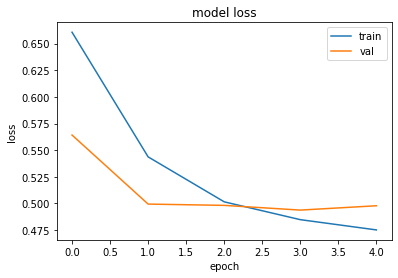

In [34]:
l, a, p, r = model_one.evaluate(test_dataset)

print('Test Loss:', l)
print('Test Accuracy:', a)
print('Test Precision:', p)
print('Test Recall:', r)
print()
plot_history_loss(history_one)

Aquí se define la aquitectura y proceso del segundo modelo.

In [35]:
model_two = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    # Agregamos dropout para reducir el overfitting
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [36]:
model_two.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', precision, recall])

In [37]:
history_two = model_two.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset,
                    validation_steps=30)

Epoch 1/10
938/938 [==============================] - 56s 21ms/step - loss: 0.6528 - accuracy: 0.6368 - precision: 0.7473 - recall: 0.6724 - val_loss: 0.5093 - val_accuracy: 0.7510 - val_precision: 0.7825 - val_recall: 0.8162
Epoch 2/10
938/938 [==============================] - 17s 18ms/step - loss: 0.5038 - accuracy: 0.7698 - precision: 0.7612 - recall: 0.7298 - val_loss: 0.4922 - val_accuracy: 0.7625 - val_precision: 0.8031 - val_recall: 0.8058
Epoch 3/10
938/938 [==============================] - 18s 19ms/step - loss: 0.4763 - accuracy: 0.7769 - precision: 0.7687 - recall: 0.7371 - val_loss: 0.4890 - val_accuracy: 0.7698 - val_precision: 0.7979 - val_recall: 0.8308
Epoch 4/10
938/938 [==============================] - 18s 19ms/step - loss: 0.4668 - accuracy: 0.7823 - precision: 0.7758 - recall: 0.7436 - val_loss: 0.4899 - val_accuracy: 0.7656 - val_precision: 0.7893 - val_recall: 0.8368
Epoch 5/10
938/938 [==============================] - 18s 19ms/step - loss: 0.4603 - accuracy: 0

313/313 [==============================] - 2s 7ms/step - loss: 0.4844 - accuracy: 0.7640 - precision: 0.8056 - recall: 0.7928
Test Loss: 0.4844164550304413
Test Accuracy: 0.763988196849823
Test Precision: 0.8055603504180908
Test Recall: 0.7927715182304382



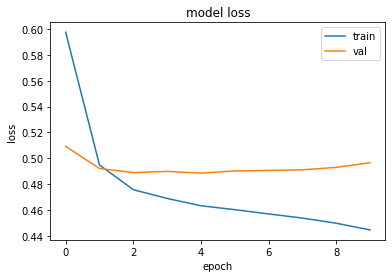

In [38]:
l, a, p, r = model_two.evaluate(test_dataset)

print('Test Loss:', l)
print('Test Accuracy:', a)
print('Test Precision:', p)
print('Test Recall:', r)
print()
plot_history_loss(history_two)

Aquí se define la aquitectura y proceso del tercer modelo.

In [39]:
model_three = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [40]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
model_three.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', precision, recall])

In [41]:
history_three = model_three.fit(train_dataset, epochs=5,
                    validation_data=valid_dataset,
                    validation_steps=30)

Epoch 1/5
938/938 [==============================] - 45s 31ms/step - loss: 0.6622 - accuracy: 0.6190 - precision_1: 0.5893 - recall_1: 0.4295 - val_loss: 0.5175 - val_accuracy: 0.7505 - val_precision_1: 0.7787 - val_recall_1: 0.8222
Epoch 2/5
938/938 [==============================] - 26s 27ms/step - loss: 0.5269 - accuracy: 0.7616 - precision_1: 0.7562 - recall_1: 0.7121 - val_loss: 0.4946 - val_accuracy: 0.7625 - val_precision_1: 0.7980 - val_recall_1: 0.8144
Epoch 3/5
938/938 [==============================] - 26s 28ms/step - loss: 0.4945 - accuracy: 0.7786 - precision_1: 0.7773 - recall_1: 0.7310 - val_loss: 0.4920 - val_accuracy: 0.7615 - val_precision_1: 0.7947 - val_recall_1: 0.8179
Epoch 4/5
938/938 [==============================] - 25s 26ms/step - loss: 0.4796 - accuracy: 0.7846 - precision_1: 0.7844 - recall_1: 0.7398 - val_loss: 0.4919 - val_accuracy: 0.7599 - val_precision_1: 0.8038 - val_recall_1: 0.7990
Epoch 5/5
938/938 [==============================] - 25s 26ms/step -

313/313 [==============================] - 3s 11ms/step - loss: 0.4872 - accuracy: 0.7609 - precision_1: 0.7983 - recall_1: 0.7977
Test Loss: 0.48723042011260986
Test Accuracy: 0.7608880400657654
Test Precision: 0.7983434796333313
Test Recall: 0.7976692914962769



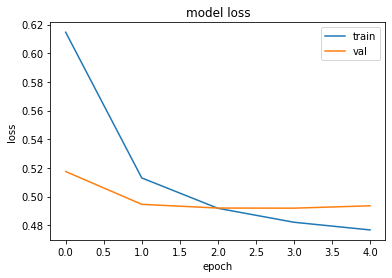

In [42]:
l, a, p, r = model_three.evaluate(test_dataset)

print('Test Loss:', l)
print('Test Accuracy:', a)
print('Test Precision:', p)
print('Test Recall:', r)
print()
plot_history_loss(history_three)

Para terminar con los modelos de Keras, aquí se muestran los resumen para cada modelo.

In [43]:
model_one.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               16512     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 152,833
Trainable params: 152,833
Non-trainable params: 0
__________________________________________________

In [44]:
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          128000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 202,369
Trainable params: 202,369
Non-trainable params: 0
________________________________________________

In [45]:
model_three.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          128000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Adicional 1: BERT
Como contenido agregado, decidimos incorporar también un modelo de BERT al vote classifier. Naturalmente, la manera en que se está haciendo esto es importando el modelo pre-entrenado de los servidores de TensorFlow, para después hacer 'Transfer Learning' con nuestro set de datos particular. En las siguientes celdas vamos explicando la construcción y entrenamiento del modelo.

Primero definimos específicamente el tipo de BERT que vamos a implementar. De acuerdo con un ejemplo de la documentación de TF (https://www.tensorflow.org/tutorials/text/classify_text_with_bert), existen varios modelos distintos de BERT, donde se varía el tamaño, número de capas, etc, pero manteniendo la esencia que propone BERT. Nosotros escogimos la variante más pequeña, llamada 'Small BERT' dado que es un caso relativamente sencillo.

In [46]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

Aquí, utilizando el segundo URL, cargamos el **preprocesador del modelo**. Este en sí ya es un modelo de BERT, pero se encarga sólo del procesamiento de los datos. Va a hacer algo muy similar a lo que hicimos aquí con Keras, es decir, ir armando un vocabulario de los datos para generar los vectores de índices.

In [47]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Y aquí se muestran algunas cosas que contiene este módulo de preprocesamiento.

In [48]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Aquí, utilizando el primer URL, se trae la otra parte del modelo de BERT. Esta parte será la encargada de ir aprendiendo de los datos para generar las predicciones.

In [49]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

Y se muestran algunas partes importantes que contiene este sub-modelo.

In [50]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626284   0.9928099  -0.18611862  0.36673862  0.15233698  0.6550447
  0.9681154  -0.94862705  0.00216154 -0.98777324  0.0684273  -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946292  0.3432122   0.3323146  ...  0.2130091   0.7102076
  -0.05771127]
 [-0.28742066  0.31980988 -0.23018472 ...  0.58454984 -0.21329743
   0.7269208 ]
 [-0.6615696   0.688769   -0.87432975 ...  0.1087725  -0.26173288
   0.47855526]
 ...
 [-0.22561064 -0.28925598 -0.07064444 ...  0.4756608   0.832771
   0.40025362]
 [-0.2982425  -0.27473134 -0.05450555 ...  0.48849788  1.0955352
   0.18163432]
 [-0.44378024  0.00930739  0.07223781 ...  0.1729011   1.1833246
   0.0789801 ]]


Ahora sí, en la siguiente función se combinan ambos sub-modelos tener un modelo completo, además de que se agregan algunas capas adicionales.

In [51]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Se construye el modelo con la función, y se saca una predicción inicial utilizando uno de los ejemplos definidos antes. Naturalmente, esta predicción aún no tiene valor dado que el modelo no ha sido entrenado.

In [52]:
bert_classifier_model = build_classifier_model()
bert_raw_result = bert_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.62119114]], shape=(1, 1), dtype=float32)


Aquí se muestra de mejor manera la arquitectura que se generó para este modelo.

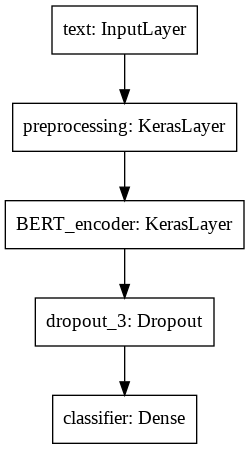

In [53]:
tf.keras.utils.plot_model(bert_classifier_model)

Definimos la función de loss, así como las métricas que queremos llevar.

In [54]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(), precision, recall]

Y aquí se define el optimizador para el modelo. Este fue tomado directamente de la documentación, dado que es lo que recomiendanque se use para el modelo de Small BERT, es especial el tipo de **AdamW**.

In [55]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Se compila el modelo y se pone a entrenar

In [56]:
bert_classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [57]:
history = bert_classifier_model.fit(x=train_dataset,
                               validation_data=valid_dataset,
                               epochs=epochs)

Epoch 1/5
938/938 [==============================] - 498s 524ms/step - loss: 0.5736 - binary_accuracy: 0.7049 - precision_1: 0.7666 - recall_1: 0.7358 - val_loss: 0.4544 - val_binary_accuracy: 0.7847 - val_precision_1: 0.8419 - val_recall_1: 0.7850
Epoch 2/5
938/938 [==============================] - 491s 524ms/step - loss: 0.4388 - binary_accuracy: 0.7980 - precision_1: 0.7917 - recall_1: 0.7625 - val_loss: 0.4417 - val_binary_accuracy: 0.7958 - val_precision_1: 0.8295 - val_recall_1: 0.8260
Epoch 3/5
938/938 [==============================] - 493s 526ms/step - loss: 0.3830 - binary_accuracy: 0.8300 - precision_1: 0.8229 - recall_1: 0.8067 - val_loss: 0.4548 - val_binary_accuracy: 0.7930 - val_precision_1: 0.8536 - val_recall_1: 0.7862
Epoch 4/5
938/938 [==============================] - 492s 524ms/step - loss: 0.3453 - binary_accuracy: 0.8508 - precision_1: 0.8460 - recall_1: 0.8289 - val_loss: 0.4599 - val_binary_accuracy: 0.7987 - val_precision_1: 0.8351 - val_recall_1: 0.8236
Epoc

Finalmente, se evalúa el modelo utilizando el testing set, además de que muestra la gráfica de los valores de loss, tanto para el set de training como el de validation.

313/313 [==============================] - 75s 239ms/step - loss: 0.4787 - binary_accuracy: 0.7972 - precision_1: 0.8404 - recall_1: 0.8116
Test Loss: 0.47870805859565735
Test Accuracy: 0.7971898317337036
Test Precision: 0.8404162526130676
Test Recall: 0.811602771282196



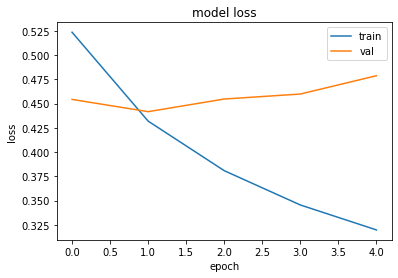

In [58]:
l, a, p, r = bert_classifier_model.evaluate(test_dataset)

print('Test Loss:', l)
print('Test Accuracy:', a)
print('Test Precision:', p)
print('Test Recall:', r)
print()
plot_history_loss(history)

Ahora sí, con los modelos ya entrenados podemos construir el vote classifier.

In [62]:
voted_classifier = VoteClassifier(NB_classifier, 
                                  MNB_classifier, 
                                  BNB_classifier, 
                                  LogisticRegression_classifier, 
                                  SGDClassifier_classifier,
                                  model_one,
                                  model_two,
                                  model_three,
                                  bert_classifier_model)

También, vamos a definir una función que utilice este objeto del vote classifier para que, dado un texto, regrese su clasificación definitiva y el porcentaje de confidence

In [63]:
def sentiment(text):
    pred, conf = voted_classifier.classify(text)
    return pred, conf

In [64]:
text = "really nice song!"
p, c = sentiment(text)
print(p, c)

1 0.6666666666666666


# 7. Applications
Ya que se entrenó el modelo viene el momento de ponerlo a prueba. Para ello se implementaron diferentes aplicaciones, donde en cada una se obtendrán textos de diversas fuentes para poder clasificarlo aquí.

## Clasificación de Tweets
La primera aplicación es que, utilizando la API de Twitter, vamos a prender un stream para recibir tweets. Cada que se reciba un tweet, se le sacará su clasificación y dependiendo de su nivel de confidence, se agregará a un archivo. La idea es generar una gráfica a partir de las clasificaciones en ese archivo. Es importante mencionar que la búsqueda de tweets se podrá hacer de dos formas:
- Por palabra clave
- Por usuario

Más adelante se especifica más sobre cada una.

Sin embargo, antes de entrar en detalle en las aplicaciones, en la siguiente celda mostramos una función que será bastante útil al sacar las clasificaciones. 

Cuando recibamos los textos del API o Stream que estemos utilizando, vamos a guardar las clasificaciones en un archivo de texto. Con este documento, que contiene las clasificaciones realizadas por nuestro modelo, podemos generar una gráfica para visualizar mejor lo que está pasando. Cada que se encuentre una clasificación positiva se sumará 1 a un contador, y se restará en el caso negativo. De esta forma nos podemos dar una mejor idea de la tendencia sobre los textos que estemos clasificando.

**Nota importante: con excepción de la clasificación de audio, todas las demás aplicaciones van a guardar las clasificaciones generadas en el mismo documento de texto. Por lo tanto, para evitar mezclar resultados, se recomienda borrar el contenido del documento antes de correr otra aplicación (también se proporciona una celda para hacerlo).**

In [65]:
def plot_text_trendline():
    style.use("ggplot")
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)

    pullData = open("twitter-out.txt","r").read()
    lines = pullData.split('\n')
    xar = []
    yar = []
    x = 0
    y = 0
    for l in lines[-200:]:
        x += 1
        y += (1 if l == '1' else -1)
        xar.append(x)
        yar.append(y)

    ax1.clear()
    ax1.plot(xar,yar)
    plt.show()

### Borrar archivo de clasificaciones
**Correr la siguiente celda en caso de que se quiera borrar el contenido del archivo con las clasificaciones.**

In [66]:
with open('twitter-out.txt', 'w') as writefile:
    writefile.write("")

Para el stream de tweets se está utilizando Tweepy, y aquí se define toda la lógica que se mencionó previamente, incluyendo hacer la clasificación del tweet y guardarla en el archivo.

In [67]:
#consumer key, consumer secret, access token, access secret.
ckey=""
csecret=""
atoken=""
asecret=""

class listener(StreamListener):
    def on_data(self, data):
        try:
            all_data = json.loads(data)
            tweet = all_data["text"]
            sentiment_value, confidence = sentiment(tweet)
            print(tweet, sentiment_value, confidence)
            if confidence*100 >= 70:
                with open('twitter-out.txt', 'a') as writefile:
                  writefile.write(f"{sentiment_value}\n")
            time.sleep(0.3)
            return True
        except:
            return True

    def on_error(self, status):
        print(status)

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

### Clasificación de tweets por palabra(s) clave
En la siguiente celda se prende el stream para buscar por una o más palabras clave. Para cambiarlas, basta con reemplazar la palabra entre comillas. Si se quieren agregar mas palabras a la lista, estas deben estar entre comillas y separadas por comas.

**El stream debe interrumpirse manualmente, cortando la ejecución de la celda.**

In [ ]:
keywords = ["happy"]
twitterStream = Stream(auth, listener())
twitterStream.filter(track=keywords)

RT @PARISDENNARD: Happy Birthday, @kayleighmcenany! https://t.co/BUfxDRzSRj 1 0.5555555555555556
RT @prodnose: Fans of
Man United
Man City
Chelsea
Arsenal
You've all had a free pass too long.
It was obvious your clubs would sell footbal… 0 0.6666666666666667
RT @Shebas_10dulkar: Least Innings taken to Score Centuries In all 3 Formats 

20 - KL Rahul
70 - Rizwan 
76 - A Shahzad 
85 - Raina 
106 -… 0 0.6666666666666667
RT @Cats_CG901: Today is Autumn’s 12th birthday! Happy birthday to our wonderful little tortoiseshell kitty! #CatsOfTwitter https://t.co/FC… 1 0.5555555555555556
RT @JohnWolfeYT: Thanks everyone who came out yesterday to help raise $32,640 for @charitywater! Very proud/happy that we were able to smas… 0 0.5555555555555556
RT @the__browngirl: Sometime we pretend to be happy just to lie to oyr fears..!! 1 0.7777777777777778
RT @StrictlyChristo: This happy pup spending his first night at his new home after being adopted from the shelter. https://t.co/IzceUV1cnF 1 0.6666666666

ProtocolError: ignored

### Clasificación de tweets por usuario
En la siguiente celda se prende el stream para buscar por un usuario. En caso de que se quiera cambiar, basta con cambiar la variable **user_name** por otro string. **Se debe colocar el nombre que tenga usuario justo después de su @**, de lo contrario Tweepy no lo va a encontrar y la celda va a marcar un error.

**Al igual que con la búsqueda por palabras, el stream debe interrumpirse manualmente, cortando la ejecución de la celda.**

In [ ]:
user_name = "IGN"
api = API(auth)

user = api.get_user(user_name)
print(f"ID del usuario encontrado: {user.id_str}")

twitterStream = Stream(auth, listener())
twitterStream.filter(follow=[user.id_str])

ID del usuario encontrado: 18927441
@IGN New* 0 0.5555555555555556
@IGN Make a game that's great and not meh and then people will gladly pay full price. https://t.co/3MFzCV5911 0 0.6666666666666667
@IGN Justice for Helena #ResidentEvil6 1 0.5555555555555556
@IGN @DillonODay 1 0.5555555555555556
@IGN They can't just expect everyone to be able to pay full price for a AAA game. More importantly, why should it b… https://t.co/SyBtSg9XmG 0 0.6666666666666667
@IGN Fuck off, make a good game then we’ll think about it 1 0.7777777777777778
@IGN Who cares? 1 1.0
RT @IGN: Days Gone creative director and writer John Garvin said that, if you love a game and want a sequel, you should "buy it at f******… 0 0.5555555555555556
@IGN I buy it at relase 0 0.7777777777777778
RT @IGN: Amazon has canceled its The Lord of the Rings MMORPG that was first announced in 2019. https://t.co/S9gYQkBfRH https://t.co/Q5jY6e… 1 0.5555555555555556
RT @IGN: Days Gone creative director and writer John Garvin said that, if

KeyboardInterrupt: ignored

Cuando se haya prendido el stream y se tengan algunos tweets ya clasificados, corremos la función para obtener la tendencia de las clasificaciones.

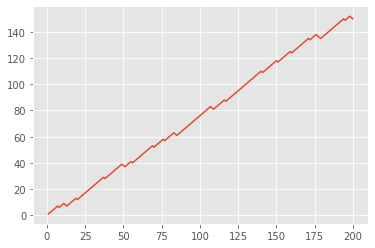

In [ ]:
plot_text_trendline()

### Clasificación de Audio
La siguiente aplicación tiene que ver con clasificación de audio. Básicamente, lo que se está haciendo es que importamos un modelo pre-entrenado de reconocimiento de texto de **SpeechBrain**. A partir de este, podemos meter un archivo de audio, transcribir el audio a texto, y posteriormente hacer la clasificación del texto con nuestro modelo. 

**Nota: los archivos de audio que se le proporcionen al modelo deben estar en formato WAV, de lo contrario puede que este no funcione correctamente.** Nosotros proporcionamos dos ejemplos para probar el modelo.

Lo primero que se hace es descargar el modelo de SpeechBrain

In [ ]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_model")

En la siguiente celda, se señala el nombre del archivo de audio, que después se transcribe usando el modelo. Para claridad, se imprime el resultado del texto transcrito.

In [ ]:
audio_file = 'ActInt1Ex2.wav'
result = asr_model.transcribe_file(audio_file).lower()
print(result)

oh my god till they was a really difficulty


Finalmente, se realiza la clasificación sobre el texto transcrito con nuestro modelo

In [ ]:
sentiment_value, confidence = sentiment(result)
print(result, sentiment_value, confidence)

oh my god till they was a really difficulty 0 0.6666666666666667


### Clasificación de Texto de Reddit
La tercera aplicación tiene que ver con clasificar texto proveniente de Reddit. Esto se realizó utilizando la librería de PRAW Lo que se está haciendo es que, dado un nombre de usuario, el API trae textos de los posts que este haya creado, incluyendo el título, cuerpo del post y comentarios. Los comentarios no necesariamente son del usuario en cuestión.

Antes de pasar a la implementación de las requests al API, en la siguiente celda declaramos una función saca las clasificaciones de un set de textos y las guarda en un archivo de texto, el mismo que leerá la función para graficar la tendencia de las clasificaciones. Esta función será muy útil para las siguientes 3 aplicaciones y la estaremos usando con las 3.

In [ ]:
def classify_text_set(texts):
    for text in texts:
        if text == '': continue
        sentiment_value, confidence = sentiment(text)
        print(text, sentiment_value, confidence)
        if confidence*100 >= 60:
            with open('twitter-out.txt', 'a') as writefile:
              writefile.write(f"{sentiment_value}\n")

Ahora sí, se crea el objeto de PRAW para hacer las clasificaciones. Aquí se necesita proporcionar un token, así como ciertos detalles de la cuenta con la que se obtuvo el token (el ID del cliente, su username y password).

In [ ]:
reddit = praw.Reddit(client_id = '',
                     client_secret = '',
                     username = '',
                     password = '',
                     user_agent='praw tutorialv1')

Ahora sí, se puede proporcionar un nombre de usuario de Reddit, y en la siguiente celda se obtiene su ID para poder obtener sus posts.

In [ ]:
redditor_name = "GuchiDroid"
redditor_id = reddit.redditor(redditor_name)
print("User chosen: {}".format(redditor_id.name))
reddit_user_content = list()
print("current elements in user content list: {}".format(len(reddit_user_content)))

User chosen: GuchiDroid
current elements in user content list: 0


En la siguiente celda se utiliza el ID obtenido para sacar los textos. **Nota:** por cuestiones de memoria y velocidad, decidimos limitar la cantidad de textos a sólo 200.

In [ ]:
print("-- User contents now being examined --")
for submission in reddit.redditor("GuchiDroid").submissions.top("all"):
  #Ideas to implement later. Separate by posts
  #sTitle = submission.title
  # nuevaLista = []
  #bText = submission.selftext 
  print("Submission Title: {}".format(submission.title))
  reddit_user_content.append(submission.title)
  print("Submission Body: \n{}\n".format(submission.selftext))
  reddit_user_content.append(submission.selftext)
  print("Comments: \n\n")
  submission.comments.replace_more(limit=0)
  for comment in submission.comments.list():
    if (len(reddit_user_content)) < 200:
      reddit_user_content.append(comment.body)
      print(comment.body)
    else:
      break
  #reddit_user_content.append()
  print("\n\n")
print("----------------------------------------------------------------------------")
print("The posts and their contents have been retrieved.")
print("Current elements in user content list: {}".format(len(reddit_user_content)))

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



-- User contents now being examined --


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Submission Title: Kyogre raid on me. Be online pls. 7849 1239 3005
Submission Body: 
7849 1239 3005

Comments: 


Hey host and people adding. If this is a raid, be sure to leave a comment with your in game name. If the host ADDS you, assume you are doing the raid and do not spam other posts please. Host, please make sure to only add those who are doing the raid! Do not leave the raid with less than 20 seconds left! Please be courteous to other raiders.

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/PokemonGoRaids) if you have any questions or concerns.*
Just added MELOncholly
JRTucker418
added Milan6
RockettBunny lvl41
Myke4
Joatk1
golfulum
added
||Oases||
TrainerElijahh lvl 37



Submission Title: Looking for Doduo!
Submission Body: 
Will add anyone :D

Comments: 




It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Added!
Added u back!



Submission Title: Adding Everyone!
Submission Body: 
Looking forward to add new safari friends.
I dunno what’s in my Safari...

Comments: 


Added, I’ll let you know what’s in your safari :)
Yours is flying type with Doduo and Tranquill. I can’t see the third get, to get get the third, you need to be online in the game and have beaten the elite 4
Added :)
I added you :)
Added!
Added
Wooo Thanks! 
Added you
Alright, I’m now online c: 
Thanks a lot btw
I added u back! :D
Added! :D
The third is Tropius. And no problem, happy to help :)
Thanks :)
Thanks!
Thanks!



Submission Title: Mega Blastoise
Submission Body: 
7849 1239 3005
Be online

Comments: 




It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Hey host and people adding. If this is a raid, be sure to leave a comment with your in game name. If the host ADDS you, assume you are doing the raid and do not spam other posts please. Host, please make sure to only add those who are doing the raid! Do not leave the raid with less than 20 seconds left! Please be courteous to other raiders. After the raid is done, add the remaining people that added you and then remove them to save your friends list space. If you decline it, they will be unable to add you in the future.

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/PokemonGoRaids) if you have any questions or concerns.*
Kilu8
Added you. Name: Kreuzl
added rockynoi1991 lvl41



Submission Title: Landorus on me!!
Submission Body: 
7849 1239 3005

Comments: 


Hey host and people adding. If this is a raid, be sure to leave a comment with your in game name. If the host ADDS you, assume you are doing the 

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.






Submission Title: Could anyone please help me identify this fly?
Submission Body: 


Comments: 





----------------------------------------------------------------------------
The posts and their contents have been retrieved.
Current elements in user content list: 57


Ya que se tienen los textos, estos se pasan por la función de preprocesamiento para quitar dos cosas principalmente: menciones a subreddits y menciones a otros usuarios. 

In [ ]:
processed_comments = [process_text(comment) for comment in reddit_user_content]
print(processed_comments[:3])

['Kyogre raid on me. Be online pls. 7849 1239 3005', '7849 1239 3005', 'Hey host and people adding. If this is a raid, be sure to leave a comment with your in game name. If the host ADDS you, assume you are doing the raid and do not spam other posts please. Host, please make sure to only add those who are doing the raid! Do not leave the raid with less than 20 seconds left! Please be courteous to other raiders.\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/ if you have any questions or concerns.*']


Finalmente, sobre los textos procesados se obtienen las clasificaciones utilizando la función antes definida.

In [ ]:
classify_text_set(processed_comments)

Kyogre raid on me. Be online pls. 7849 1239 3005 1 0.5555555555555556
7849 1239 3005 1 1.0
Hey host and people adding. If this is a raid, be sure to leave a comment with your in game name. If the host ADDS you, assume you are doing the raid and do not spam other posts please. Host, please make sure to only add those who are doing the raid! Do not leave the raid with less than 20 seconds left! Please be courteous to other raiders.

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/ if you have any questions or concerns.* 1 0.6666666666666666
Just added MELOncholly 1 0.8888888888888888
JRTucker418 1 0.8888888888888888
added Milan6 1 0.8888888888888888
RockettBunny lvl41 1 0.5555555555555556
Myke4 1 0.6666666666666666
Joatk1 1 0.7777777777777778
golfulum 1 0.5555555555555556
added 1 1.0
||Oases|| 1 0.8888888888888888
TrainerElijahh lvl 37 1 0.5555555555555556
Looking for Doduo! 1 0.6666666666666666
Will add anyone  happyemoticon  

Al terminar de clasificar, se puede correr la siguiente celda para ver la gráfica con la tendencia de las clasificaciones.

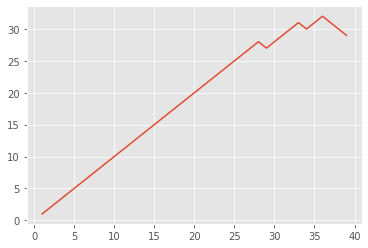

In [ ]:
plot_text_trendline()

### Adicional 2: Clasificación de Texto de Youtube
La cuarta aplicación que nos pareció muy interesante es clasificar texto proveniente de los comentarios de un video específico de Youtube. Esto lo vamos a hacer utilizando la API que proporciona Youtube, con antemano obtuvimos una llave para poder hacer los requests. (https://developers.google.com/youtube/v3/docs/commentThreads/list)

Primero declaramos dos cosas muy importante, la llave para poder hacer las requests al API, así como el objeto que se encargará de hacer dichas requests.

In [ ]:
yt_api_key = ''
youtube = build('youtube', 'v3', developerKey=yt_api_key)

Para poder hacer las requests, necesitamos obtener el ID del video del cual queremos extraer sus comentarios. Esta funcion hace la request correspondiente para que, dado un URL, se pueda obtener el ID del video.

In [ ]:
def get_video_id_from_url(video_url):   
    response = youtube.search().list(
        part="snippet",
        maxResults=1,
        q=video_url
    ).execute()
    
    if len(response['items']) == 0:
        print("Incorrect URL, please try again")
        return ""
    
    videoId = response['items'][0]['id']['videoId']
    return videoId

La siguiente celda muestra otra función, la cual está encargada de traer los comentarios del ID proporcionado. 

Por razones de memoria y velocidad, decidimos limitar la cantidad que trae a sólo **200 comentarios**. Sabemos que hay video con miles, incluso millones, de comentarios, sin embargo, para este proyecto creemos que 200 sería suficiente para brindar un panorama suficiente bueno.

In [ ]:
def get_video_comments(video_id):
    all_comments = []

    # retrieve youtube video results
    video_response = youtube.commentThreads().list(
        part="snippet, replies",
        maxResults = 200,
        videoId=video_id
    ).execute()    
    
    # iterate video response
    while video_response:
        for item in video_response['items']:
            # Extracting comments
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            
            all_comments.append(comment)
            
        if 'nextPageToken' in video_response and len(all_comments) < 200:
            video_response = youtube.commentThreads().list(
                part = 'snippet, replies',
                videoId = video_id
            ).execute()
        else:
            break
    
    return all_comments

Finalmente, en la siguiente celda se puede escribir un URL para obtener sus comentarios y clasificarlos.

**Nota importante:** el URL tiene que proporcionarse sin los parámetros que usualmente agrega Youtube, aquí se muestra un URL correcto vs. uno incorrecto.
- Correcto: https://www.youtube.com/watch?v=XXXXXXXXXXX
- Incorrecto: https://www.youtube.com/watch?v=XXXXXXXXXXX&t=4973s

**Nota importante 2:** Youtube tiene restringido su API para que tenga un límite de 10,000 unidades máximo que se pueden utilizar por día. La operación para buscar el ID consume 100 unidades mientras que la de recuperar los comentarios consume 1 unidad. 

In [ ]:
video_url = "https://www.youtube.com/watch?v=W5AZeNGB6Ds"
video_id = get_video_id_from_url(video_url)
video_comments = get_video_comments(video_id)
print(len(video_comments))

200


In [ ]:
processed_comments = [process_text(comment) for comment in video_comments]
print(processed_comments[:3])

['Me trás Nostalgia e gratidão 3', 'I listen to this every day and I think it amazing!THANK YOU', 'Amazing, tysm']


In [ ]:
classify_text_set(processed_comments)

Me trás Nostalgia e gratidão 3 0 0.5555555555555556
I listen to this every day and I think it amazing!THANK YOU 1 0.6666666666666666
Amazing, tysm 1 0.5555555555555556
this playlist fills you with NOSTALGIA 1 0.6666666666666666
This keeps me calm during online school. Thanks man 1 0.7777777777777778
Zelda is the best thing I know.. in this world of ours. 0 0.5555555555555556
the music is awesome 1 0.5555555555555556
1:26:53 hits me so hard - 2017 feels so nostalgic. what a beautiful game, had great moments with my friend playing this! 1 0.8888888888888888
The best ever. I love listening to this while stretching 💛 1 0.7777777777777778
Next Video NO! loop it for ever :..) 0 0.7777777777777778
I like how chill the Zelda community is in this comments. 1 0.6666666666666666
ever since ocarina of times these games have all used an ocarina. 0 0.6666666666666667
I love this I use it for dnd and for studying.  Thanks 1 0.6666666666666666
Hey guys, The purpose of my youtube channel is to make a a

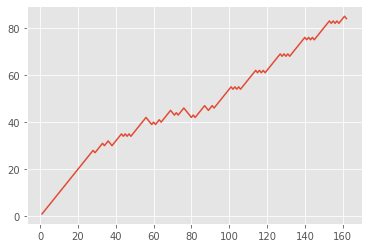

In [ ]:
plot_text_trendline()

### Adicional 3: Clasificación de Lyrics de Genius.com
La quinta y última aplicación, que nos pareció muy interesante es la clasificación de letras de canciones provenientes de Genius.com. Tradicionalmente las canciones suelen tener textos muy expresivos, por lo que nos pareció un muy buen lugar donde probar nuestros modelos.

Generamos una aplicación en la Client API de Genius.com (http://genius.com/api-clients). **Nota**: es necesario tener una cuenta de Genius para poder usar su API. De aquí también seleccionamos algunos parámetros para la request que queremos hacer.

In [ ]:
# Configuración de la clase Genius
token_genius = ''
genius = Genius(token_genius)
genius.remove_section_headers = True
genius.excluded_terms = ["(Remix)", "(Live)"]

En la siguiente celda, se puede seleccionar el nombre del artista y la canción sobre la cual se quieren obtener los lyrics. **Nota:** ambos parámetros son necesarios para poder hacer la request.

In [ ]:
## By song
artist_name = 'Weyes Blood'
songname = "Andromeda"
song = genius.search_song(songname, artist_name)
print(song.lyrics)

Searching for "Andromeda" by Weyes Blood...
Done.
Andromeda's a big wide open galaxy
Nothing in it for me
'Cept my heart that's lazy
Runnin' from my own life now
I'm really turnin' some time
Looking up to the sky for something I may never find

Stop calling
It's time to let me be
If you think you can save me
I dare you to try

Lift the heart from the depths it's fallen to
We all want something new
But can't seem to follow through
Something's better than nothing
Or so that I thought
Now I know it's just one dream
All these others gonna tear me apart

Love is calling
It's time to let it through
Find a love that will make you
I dare you to try

Crazy guy
I think this is deep
Think it's meant to be
More than anything I can think of
I'm ready to try

Treat me right
I'm still a good man's daughter
Let me in if I break
And be quiet if I shatter
Gettin' tired of looking
You know that I hate the game
Don't wanna waste any more time
You know I been holdin' out

Love is calling
It's time to give 

La API nos regresa el texto como un sólo string, sin embargo, nosotros queremos hacer las clasificaciones por verso. En la siguiente celda separamos los lyrics por vero, antes de clasificarlos. Cabe mencionar también que a estos no les hacemos ningún otro tipo de procesamiento. Esto es debido a que este ya viene prácticamente limpio del API, no creemos que haya necesidad de pasarlo por nuestra función de procesamiento.

In [ ]:
lyrics = song.lyrics.splitlines()

Ya con los lyrics, corremos la función para clasificarlos por verso

In [ ]:
classify_text_set(lyrics)

Andromeda's a big wide open galaxy 0 0.5555555555555556
Nothing in it for me 0 0.7777777777777778
'Cept my heart that's lazy 0 0.7777777777777778
Runnin' from my own life now 1 0.5555555555555556
I'm really turnin' some time 0 0.7777777777777778
Looking up to the sky for something I may never find 0 0.8888888888888888
Stop calling 0 0.6666666666666667
It's time to let me be 1 0.5555555555555556
If you think you can save me 1 0.5555555555555556
I dare you to try 1 0.6666666666666666
Lift the heart from the depths it's fallen to 1 0.6666666666666666
We all want something new 0 0.8888888888888888
But can't seem to follow through 0 0.8888888888888888
Something's better than nothing 0 0.5555555555555556
Or so that I thought 0 0.7777777777777778
Now I know it's just one dream 0 0.5555555555555556
All these others gonna tear me apart 0 0.8888888888888888
Love is calling 0 0.5555555555555556
It's time to let it through 1 0.5555555555555556
Find a love that will make you 1 0.5555555555555556
I 

Y finalmente, corremos la función para generar la gráfica de tendencia.

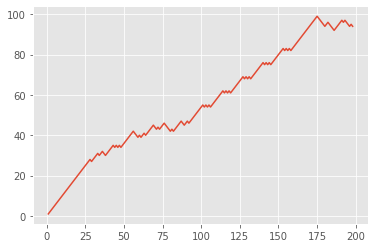

In [ ]:
plot_text_trendline()

In [ ]:
# Comando para obtener el archivo de requerimientos
# pip freeze > requirements.txt